
0: 640x480 1 person, 1 couch, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 1 cell phone, 145.1ms
Speed: 22.4ms preprocess, 145.1ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 480)
All detected classes:
  - laptop (confidence: 0.88)
  - keyboard (confidence: 0.87)
  - person (confidence: 0.78)
  - cell phone (confidence: 0.54)
  - mouse (confidence: 0.50)
  - couch (confidence: 0.38)
  - tv (confidence: 0.33)
Detected mouse: mouse with confidence: 0.50
Mouse detected, focusing on mouse.
Selected box for SAM: mouse at [1038.2867431640625, 758.5213623046875, 1399.476806640625, 1070.8533935546875] with confidence 0.50

0: 640x480 1 person, 1 couch, 1 tv, 1 laptop, 1 mouse, 1 keyboard, 1 cell phone, 145.1ms
Speed: 22.4ms preprocess, 145.1ms inference, 12.2ms postprocess per image at shape (1, 3, 640, 480)
All detected classes:
  - laptop (confidence: 0.88)
  - keyboard (confidence: 0.87)
  - person (confidence: 0.78)
  - cell phone (confidence: 0.54)
  - mouse (confidence: 0.50)
 

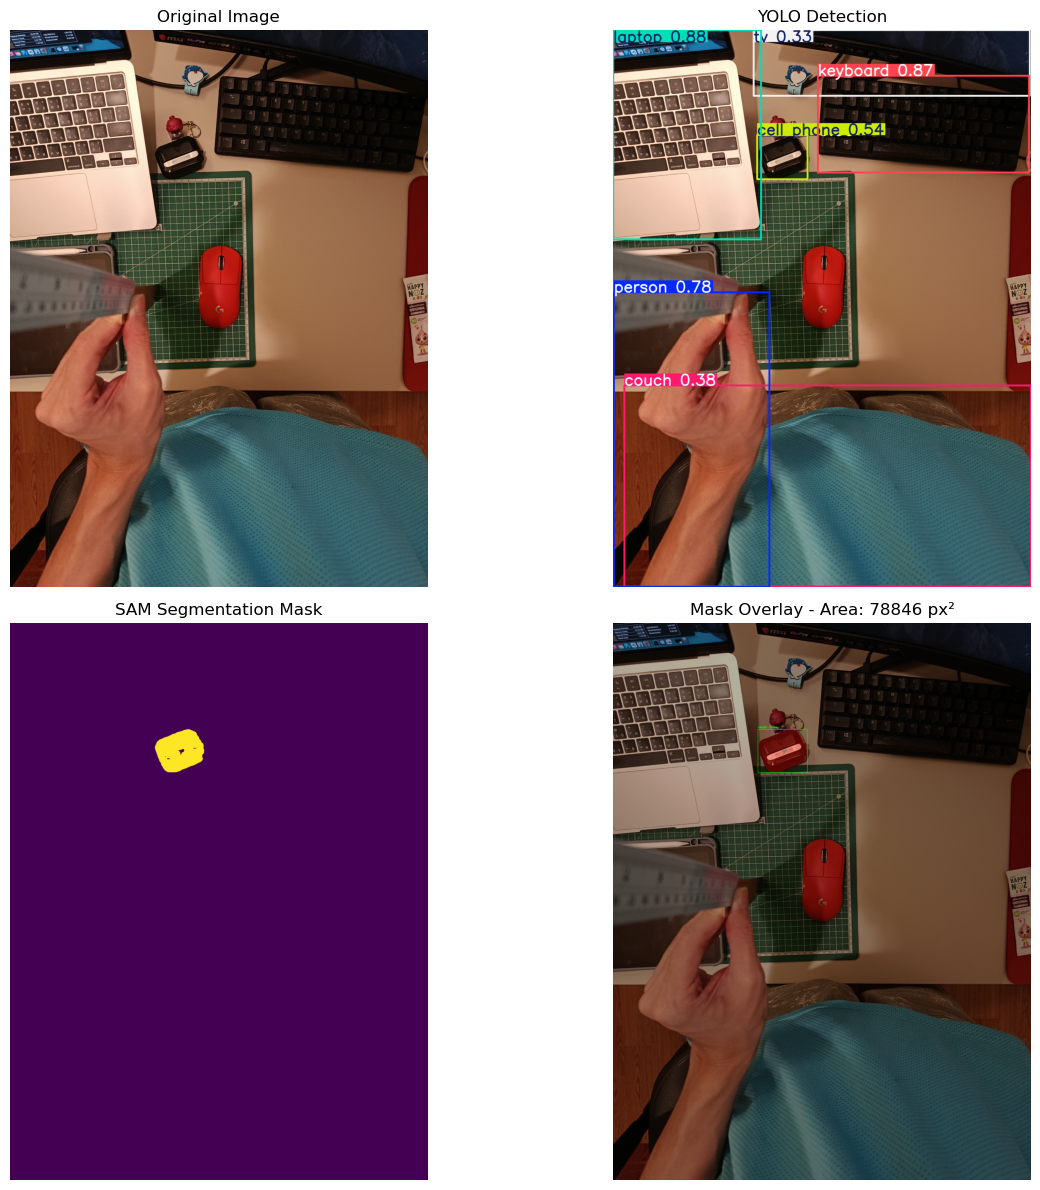


Mask shape: (4000, 3000)
Unique mask values: [False  True]


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO, SAM

def measure_object_yolo_sam(image_path, yolo_model='yolov8n.pt', sam_model='sam_b.pt'):
    """
    Focus on mouse detection first, fallback to other objects if no mouse found.
    """
    # Load models
    yolo = YOLO(yolo_model)
    sam = SAM(sam_model)

    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found or cannot be read: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run YOLO inference
    yolo_results = yolo(img)
    result = yolo_results[0]

    # Print all detected classes for debugging
    print("All detected classes:")
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        confidence = float(box.conf[0])
        print(f"  - {class_name} (confidence: {confidence:.2f})")

    # 1. Try to detect mouse first
    mouse_detections = []
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = result.names[class_id]
        confidence = float(box.conf[0])
        if class_name in ['mouse', 'computer mouse']:
            mouse_detections.append((box, class_name, confidence))
            print(f"Detected mouse: {class_name} with confidence: {confidence:.2f}")

    if mouse_detections:
        print("Mouse detected, focusing on mouse.")
        # Pick the mouse with highest confidence
        best_box, best_class, best_conf = max(mouse_detections, key=lambda x: x[2])
    else:
        print("No mouse detected. Focusing on other objects except person.")
        # 2. Fallback: detect any object except person and mouse
        detections = []
        for box in result.boxes:
            class_id = int(box.cls[0])
            class_name = result.names[class_id]
            confidence = float(box.conf[0])
            if class_name not in ['person', 'mouse', 'computer mouse']:
                detections.append((box, class_name, confidence))
                print(f"Detected: {class_name} with confidence: {confidence:.2f}")
        if not detections:
            print("No valid object detected. Showing all detections:")
            for box in result.boxes:
                class_id = int(box.cls[0])
                class_name = result.names[class_id]
                confidence = float(box.conf[0])
                print(f"  - {class_name} (confidence: {confidence:.2f})")
            return None
        # Pick the object with highest confidence
        best_box, best_class, best_conf = max(detections, key=lambda x: x[2])

    x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()
    print(f"Selected box for SAM: {best_class} at [{x1}, {y1}, {x2}, {y2}] with confidence {best_conf:.2f}")

    # Use bounding box as prompt for SAM
    bbox = [int(x1), int(y1), int(x2), int(y2)]

    # Run SAM segmentation with bbox prompt
    sam_results = sam(img, bboxes=[bbox])

    # Get the mask
    if sam_results[0].masks is not None:
        mask = sam_results[0].masks.data[0].cpu().numpy()

        # Calculate measurements from mask
        mask_binary = (mask > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            length_pixels = max(w, h)

            # Calculate mask area and perimeter
            mask_area = cv2.contourArea(largest_contour)
            perimeter = cv2.arcLength(largest_contour, True)

            print(f"\nObject measurements:")
            print(f"Length: {length_pixels:.2f} pixels")
            print(f"Width: {w:.2f} pixels")
            print(f"Height: {h:.2f} pixels")
            print(f"Mask Area: {mask_area:.2f} square pixels")
            print(f"Perimeter: {perimeter:.2f} pixels")

            # Create visualization
            fig, axes = plt.subplots(2, 2, figsize=(14, 12))

            # Original image
            axes[0, 0].imshow(img_rgb)
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')

            # YOLO detection
            yolo_annotated = result.plot()
            yolo_annotated_rgb = cv2.cvtColor(yolo_annotated, cv2.COLOR_BGR2RGB)
            axes[0, 1].imshow(yolo_annotated_rgb)
            axes[0, 1].set_title('YOLO Detection')
            axes[0, 1].axis('off')

            # SAM mask
            axes[1, 0].imshow(mask, cmap='viridis')
            axes[1, 0].set_title('SAM Segmentation Mask')
            axes[1, 0].axis('off')

            # Overlay mask on original
            overlay = img_rgb.copy()
            mask_colored = np.zeros_like(img_rgb)
            mask_colored[:, :, 0] = mask * 255  # Red channel
            overlay = cv2.addWeighted(overlay, 0.7, mask_colored, 0.3, 0)

            # Draw bounding box on overlay
            cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(overlay, f'Length: {length_pixels:.0f}px', (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            axes[1, 1].imshow(overlay)
            axes[1, 1].set_title(f'Mask Overlay - Area: {mask_area:.0f} px²')
            axes[1, 1].axis('off')

            plt.tight_layout()
            plt.show()

            return {
                'length': length_pixels,
                'width': w,
                'height': h,
                'area': mask_area,
                'perimeter': perimeter,
                'mask': mask,
                'bbox': bbox
            }
    else:
        print("SAM segmentation failed")
        return None

# Install required packages if needed
# !pip install ultralytics

# Usage - Models will download automatically on first run
# SAM models: 'sam_b.pt' (base), 'sam_l.pt' (large)
result = measure_object_yolo_sam('/Users/niner9/Documents/GitHub/URD-2_BlackPigProject/measure_length/dataset/xiaomi/xiaomi_vmouse60.jpg', sam_model='sam_b.pt')

if result is not None:
    print(f"\nMask shape: {result['mask'].shape}")
    print(f"Unique mask values: {np.unique(result['mask'])}")